In [1]:
import os
import sys

notebook_dir = os.getcwd()
app_path = os.path.abspath(os.path.join(notebook_dir, "../"))
if app_path not in sys.path:
    sys.path.insert(0, app_path)

In [2]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

## 노드 정의

In [ ]:
import os
from graphparser.state import GraphState
import graphparser.core as parser_core
import graphparser.pdf as pdf


# 문서 분할
split_pdf_node = pdf.SplitPDFFilesNode(batch_size=10)

# Layout Analyzer
layout_analyze_node = parser_core.LayoutAnalyzerNode(os.environ.get("UPSTAGE_API_KEY"))

# 페이지 요소 추출
page_element_extractor_node = parser_core.ExtractPageElementsNode()

# 이미지 자르기
image_cropper_node = parser_core.ImageCropperNode()

# 테이블 자르기
table_cropper_node = parser_core.TableCropperNode()

# 페이지별 텍스트 추출
extract_page_text = parser_core.ExtractPageTextNode()

# 페이지별 요약
page_summary_node = parser_core.CreatePageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 이미지 요약
image_summary_node = parser_core.CreateImageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 요약
table_summary_node = parser_core.CreateTableSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 Markdown 추출
table_markdown_extractor = parser_core.TableMarkdownExtractorNode()

## 그래프 정의

In [ ]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# LangGraph을 생성
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("split_pdf_node", split_pdf_node)
workflow.add_node("layout_analyzer_node", layout_analyze_node)
workflow.add_node("page_element_extractor_node", page_element_extractor_node)
workflow.add_node("image_cropper_node", image_cropper_node)
workflow.add_node("table_cropper_node", table_cropper_node)
workflow.add_node("extract_page_text_node", extract_page_text)
workflow.add_node("page_summary_node", page_summary_node)
workflow.add_node("image_summary_node", image_summary_node)
workflow.add_node("table_summary_node", table_summary_node)
workflow.add_node("table_markdown_node", table_markdown_extractor)

# 각 노드들을 연결합니다.
workflow.add_edge("split_pdf_node", "layout_analyzer_node")
workflow.add_edge("layout_analyzer_node", "page_element_extractor_node")
workflow.add_edge("page_element_extractor_node", "image_cropper_node")
workflow.add_edge("page_element_extractor_node", "table_cropper_node")
workflow.add_edge("page_element_extractor_node", "extract_page_text_node")
workflow.add_edge("image_cropper_node", "page_summary_node")
workflow.add_edge("table_cropper_node", "page_summary_node")
workflow.add_edge("extract_page_text_node", "page_summary_node")
workflow.add_edge("page_summary_node", "image_summary_node")
workflow.add_edge("page_summary_node", "table_summary_node")
workflow.add_edge("image_summary_node", END)
workflow.add_edge("table_summary_node", "table_markdown_node")
workflow.add_edge("table_markdown_node", END)

workflow.set_entry_point("split_pdf_node")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

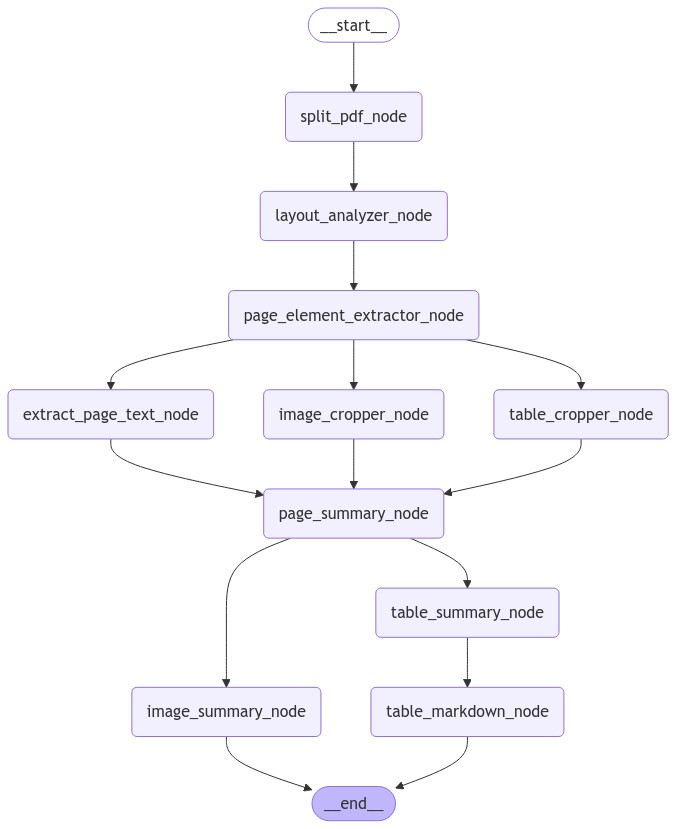

In [ ]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

아래의 링크에서 데이터를 다운로드 받습니다.
- [샘플 데이터 링크](https://www.innovation.go.kr/ucms/bbs/B0000051/view.do?nttId=3801&menuNo=300145&searchType=&pageIndex=&searchType=)

In [ ]:
### 설정 파라미터 ###
FILEPATH = "/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf"
LANGUAGE = "Korean"
### 설정 파라미터 ###

In [ ]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": "research-paper"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(filepath=FILEPATH, language=LANGUAGE)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

총 페이지 수: 6
분할 PDF 생성: /Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.pdf
"Output from node 'split_pdf_node':"
'---'
{ 'split_filepaths': [ '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 '
                       '8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.pdf']}
'\n---\n'
"Output from node 'layout_analyzer_node':"
'---'
{ 'analyzed_files': [ '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 '
                      '8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.json']}
'\n---\n'
("data: {'api': '2.0', 'content': {'html': '<header id=\\'0\\' "
 "style=\\'font-size:16px\\'>Transactions of KSAE, Vol. 27, No. 1, pp.1-6 "
 "(January, 2019)</header>\\n<br><header id=\\'1\\' "
 "style=\\'font-size:14px\\'>Copyright Ⓒ 2019 KSAE / 158-01<br>pISSN 1225-6382 "
 '

In [ ]:
state = app.get_state(config).values

In [ ]:
state

{'filepath': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
 'page_numbers': [0, 1, 2, 3, 4, 5],
 'split_filepaths': ['/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.pdf'],
 'analyzed_files': ['/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.json'],
 'page_elements': {0: {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'category': 'header',
     'content': {'html': "<header id='0' style='font-size:16px'>Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)</header>",
      'markdown': 'Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)',
      'text': 'Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)'},
     'coordin

## 저장 및 불러오기

In [ ]:
from graphparser.layout_utils import save_state, load_state

# 상태 저장
save_state(state, FILEPATH)

# 상태 불러오기
loaded_state = load_state(FILEPATH)
loaded_state

{'filepath': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
 'page_numbers': [0, 1, 2, 3, 4, 5],
 'split_filepaths': ['/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.pdf'],
 'analyzed_files': ['/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.json'],
 'page_elements': {0: {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'category': 'header',
     'content': {'html': "<header id='0' style='font-size:16px'>Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)</header>",
      'markdown': 'Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)',
      'text': 'Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)'},
     'coordin

In [ ]:
state = loaded_state

In [ ]:
state["image_summary"]

{26: '<image>\n<title>\n인터쿨러 구조 및 기능\n</title>\n<summary>\n이 이미지는 차량의 엔진룸에 장착된 인터쿨러의 구조와 기능을 설명하고 있다. 인터쿨러는 엔진의 성능을 극대화하기 위해 필수적인 부품으로, 공기 흡입과 배기 과정에서 열을 감소시켜 엔진의 효율성을 높인다. 상단 이미지는 차량의 엔진룸 내 인터쿨러의 위치를 보여주고, 하단 이미지는 인터쿨러와 관련된 공기 흐름을 나타낸다.\n</summary>\n<entities> \n- 인터쿨러\n- 내부 연소 엔진\n- 흡입 공기\n- 배기 공기 터빈\n</entities>\n<hypothetical_questions>\n1. 인터쿨러의 주요 기능은 무엇인가요?\n2. 인터쿨러가 엔진 성능에 미치는 영향은 어떤가요?\n3. 인터쿨러의 구조적 제약은 무엇인가요?\n4. 인터쿨러의 열전달 효율을 높이기 위한 연구는 어떤 것이 있나요?\n5. 차량의 엔진룸에서 인터쿨러의 위치는 왜 중요한가요?\n</hypothetical_questions>\n</image>',
 28: '<image>\n<title>\n인터쿨러 구조 및 기능\n</title>\n<summary>\n이 이미지는 인터쿨러의 구조를 보여주며, 주요 구성 요소인 탱크 인렛, 코어, 탱크 아울렛, 압력 아울렛, 그리고 질량 유입구를 나타냅니다. 인터쿨러는 엔진 성능을 극대화하기 위해 설계되었으며, 내부 저항을 줄이기 위한 다양한 연구가 진행되고 있습니다.\n</summary>\n<entities> \n- 인터쿨러\n- 탱크 인렛\n- 코어\n- 탱크 아울렛\n- 압력 아울렛\n- 질량 유입구\n</entities>\n<hypothetical_questions>\n1. 인터쿨러의 주요 기능은 무엇인가요?\n2. 탱크 인렛과 압력 아울렛의 역할은 무엇인가요?\n3. 인터쿨러의 성능을 향상시키기 위한 연구는 어떤 것들이 있나요?\n4. 인터쿨러의 구조적 제약은 무엇인가요?\n5. CFD 해석 결과는 인터쿨러 설계에 어떤 영향

## Markdown 생성

In [ ]:
# print(state["image_summary"][24])

In [ ]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re


def extract_tag_content(content, tag):
    pattern = rf"<{tag}>(.*?)</{tag}>"
    match = re.search(pattern, content, re.DOTALL)

    if match:
        return match.group(1).strip()
    else:
        return None


def extract_non_tag_content(content, tag):
    pattern = rf"<{tag}>.*?</{tag}>"
    result = re.sub(pattern, "", content, flags=re.DOTALL)
    return result.strip()

### Image, Table 에서 추출된 데이터 Vector DB 생성을 위한 문서 생성

- Title, Summary, Entities 는 임베딩 검색에 걸리기 위한 문서로 생성
- hypothetical_questions 는 임베딩 검색에 걸리기 위한 문서로 생성

In [ ]:
for i in state["image_summary"]:
    print(
        state["image_summary"][i],
        end="\n=============================================================================================================================================================\n",
    )

<image>
<title>
인터쿨러 구조 및 기능
</title>
<summary>
이 이미지는 차량의 엔진룸에 장착된 인터쿨러의 구조와 기능을 설명하고 있다. 인터쿨러는 엔진의 성능을 극대화하기 위해 필수적인 부품으로, 공기 흡입과 배기 과정에서 열을 감소시켜 엔진의 효율성을 높인다. 상단 이미지는 차량의 엔진룸 내 인터쿨러의 위치를 보여주고, 하단 이미지는 인터쿨러와 관련된 공기 흐름을 나타낸다.
</summary>
<entities> 
- 인터쿨러
- 내부 연소 엔진
- 흡입 공기
- 배기 공기 터빈
</entities>
<hypothetical_questions>
1. 인터쿨러의 주요 기능은 무엇인가요?
2. 인터쿨러가 엔진 성능에 미치는 영향은 어떤가요?
3. 인터쿨러의 구조적 제약은 무엇인가요?
4. 인터쿨러의 열전달 효율을 높이기 위한 연구는 어떤 것이 있나요?
5. 차량의 엔진룸에서 인터쿨러의 위치는 왜 중요한가요?
</hypothetical_questions>
</image>
<image>
<title>
인터쿨러 구조 및 기능
</title>
<summary>
이 이미지는 인터쿨러의 구조를 보여주며, 주요 구성 요소인 탱크 인렛, 코어, 탱크 아울렛, 압력 아울렛, 그리고 질량 유입구를 나타냅니다. 인터쿨러는 엔진 성능을 극대화하기 위해 설계되었으며, 내부 저항을 줄이기 위한 다양한 연구가 진행되고 있습니다.
</summary>
<entities> 
- 인터쿨러
- 탱크 인렛
- 코어
- 탱크 아울렛
- 압력 아울렛
- 질량 유입구
</entities>
<hypothetical_questions>
1. 인터쿨러의 주요 기능은 무엇인가요?
2. 탱크 인렛과 압력 아울렛의 역할은 무엇인가요?
3. 인터쿨러의 성능을 향상시키기 위한 연구는 어떤 것들이 있나요?
4. 인터쿨러의 구조적 제약은 무엇인가요?
5. CFD 해석 결과는 인터쿨러 설계에 어떤 영향을 미치나요?
</hypothetical_questions>
</image>
<image>
<ti

In [ ]:
# print(extract_tag_content(state["image_summary"][24], "hypothetical_questions"))

In [ ]:
# print(extract_non_tag_content(state["image_summary"][24], "hypothetical_questions"))

### Table

In [ ]:
state["table_summary"]

{36: '<table>\n<title>\n터보차저 인터쿨러 탱크 형상 최적화\n</title>\n<summary>\n이 연구는 터보차저의 효율 증대를 위해 인터쿨러 탱크의 형상을 최적화하고 내부 압력 강하를 개선하는 것을 목표로 합니다. 주요 설계 변수로는 탱크 외곽 경사, 필렛의 외부 및 내부 곡률 반경, 브릿지 위치가 포함됩니다.\n</summary>\n<entities> \n- 설계 변수: \n  - A) 탱크 외곽 경사: -R100, R0, +R100\n  - B) 필렛 외부 곡률 반경: -30, 30, 50\n  - C) 필렛 내부 곡률 반경: R0, R5, R10\n  - D) 브릿지 위치: No bridge, 기울어짐\n</entities>\n<data_insights>\n- 목표: 내부 저항 최소화 및 압력 강하 ΔP의 최적화\n- 분석 방법: CFD 해석 및 다구찌(Taguchi) 기법 활용\n- S/N비 및 MSD 계산을 통해 최적 설계 도출\n</data_insights>\n<hypothetical_questions>\n1. 탱크 외곽 경사가 효율에 미치는 영향은 무엇인가요?\n2. 필렛의 곡률 반경이 압력 강하에 어떤 영향을 미치나요?\n3. 브릿지 위치의 변화가 유체 흐름에 미치는 영향은 무엇인가요?\n4. 다구찌 기법을 사용한 이유는 무엇인가요?\n5. S/N비를 통해 최적 설계를 도출하는 과정은 어떻게 되나요?\n</hypothetical_questions>\n</table>',
 46: '<table>\n<title>\n터보차저 인터쿨러 탱크 형상 최적화 연구\n</title>\n<summary>\n이 연구는 터보차저의 효율 증대를 위해 인터쿨러 탱크의 형상 최적화 및 내부 압력 강하 개선을 목표로 하고 있습니다. 다양한 설계 변수를 통해 최적의 성능을 도출하기 위한 분석이 진행되었습니다.\n</summary>\n<entities> \n- 연구 목적: 터보차저 효율 증대\n- 주요 설계 변수: 탱크 외곽 경사, 필렛 외부 및 내부

In [ ]:
# XML 파싱을 위해 import 문을 추가합니다
import xml.etree.ElementTree as ET


def convert_to_markdown_table(table_summary):
    html = "<table>\n"

    # table_summary가 문자열인 경우를 처리합니다
    if isinstance(table_summary, str):
        # XML 파싱을 사용하여 문자열에서 데이터를 추출합니다
        root = ET.fromstring(table_summary)
        for child in root:
            html += f"  <tr>\n    <th>{child.tag}</th>\n    <td>"

            if child.tag in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in child.text.strip().split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif child.tag == "hypothetical_questions":
                html += "<ol>\n"
                for item in child.text.strip().split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += child.text.strip()

            html += "</td>\n  </tr>\n"
    else:
        # 기존의 딕셔너리 처리 로직을 유지합니다
        for key, value in table_summary.items():
            html += f"  <tr>\n    <th>{key}</th>\n    <td>"

            if key in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in value.split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif key == "hypothetical_questions":
                html += "<ol>\n"
                for item in value.split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += value

            html += "</td>\n  </tr>\n"

    html += "</table>"
    return html

In [ ]:
# print(state["table_summary"][31])

In [ ]:
# markdown_table = convert_to_markdown_table(state["table_summary"][31])
# print(markdown_table)

In [ ]:
state

{'filepath': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
 'page_numbers': [0, 1, 2, 3, 4, 5],
 'split_filepaths': ['/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.pdf'],
 'analyzed_files': ['/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006_0000_0005.json'],
 'page_elements': {0: {'image_elements': [],
   'table_elements': [],
   'text_elements': [{'category': 'header',
     'content': {'html': "<header id='0' style='font-size:16px'>Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)</header>",
      'markdown': 'Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)',
      'text': 'Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)'},
     'coordin

In [ ]:
state["table_summary"]

{36: '<table>\n<title>\n터보차저 인터쿨러 탱크 형상 최적화\n</title>\n<summary>\n이 연구는 터보차저의 효율 증대를 위해 인터쿨러 탱크의 형상을 최적화하고 내부 압력 강하를 개선하는 것을 목표로 합니다. 주요 설계 변수로는 탱크 외곽 경사, 필렛의 외부 및 내부 곡률 반경, 브릿지 위치가 포함됩니다.\n</summary>\n<entities> \n- 설계 변수: \n  - A) 탱크 외곽 경사: -R100, R0, +R100\n  - B) 필렛 외부 곡률 반경: -30, 30, 50\n  - C) 필렛 내부 곡률 반경: R0, R5, R10\n  - D) 브릿지 위치: No bridge, 기울어짐\n</entities>\n<data_insights>\n- 목표: 내부 저항 최소화 및 압력 강하 ΔP의 최적화\n- 분석 방법: CFD 해석 및 다구찌(Taguchi) 기법 활용\n- S/N비 및 MSD 계산을 통해 최적 설계 도출\n</data_insights>\n<hypothetical_questions>\n1. 탱크 외곽 경사가 효율에 미치는 영향은 무엇인가요?\n2. 필렛의 곡률 반경이 압력 강하에 어떤 영향을 미치나요?\n3. 브릿지 위치의 변화가 유체 흐름에 미치는 영향은 무엇인가요?\n4. 다구찌 기법을 사용한 이유는 무엇인가요?\n5. S/N비를 통해 최적 설계를 도출하는 과정은 어떻게 되나요?\n</hypothetical_questions>\n</table>',
 46: '<table>\n<title>\n터보차저 인터쿨러 탱크 형상 최적화 연구\n</title>\n<summary>\n이 연구는 터보차저의 효율 증대를 위해 인터쿨러 탱크의 형상 최적화 및 내부 압력 강하 개선을 목표로 하고 있습니다. 다양한 설계 변수를 통해 최적의 성능을 도출하기 위한 분석이 진행되었습니다.\n</summary>\n<entities> \n- 연구 목적: 터보차저 효율 증대\n- 주요 설계 변수: 탱크 외곽 경사, 필렛 외부 및 내부

In [ ]:
def create_document(content, metadata):
    """
    문서 객체를 생성합니다.

    Args:
        content (str): 문서의 내용
        metadata (dict): 문서의 메타데이터

    Returns:
        Document: 생성된 문서 객체
    """
    return Document(page_content=content, metadata=metadata)


def process_image_element(element, state, page_number):
    """
    이미지 요소를 처리합니다.

    Args:
        element (dict): 이미지 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체 리스트
    """
    image_id = element["id"]
    image_summary = state["image_summary"][image_id]
    image_path = state["images"][image_id]
    image_path_md = f"![{image_path}]({image_path})"

    # image_summary_md = convert_to_markdown_table(image_summary)
    markdown = f"{image_path_md}"

    image_summary_clean = extract_non_tag_content(
        image_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            image_summary_clean,
            {
                "type": "image",
                "image": image_path,
                "page": page_number,
                "source": state["filepath"],
                "id": image_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        image_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "image": image_path,
                    "summary": image_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": image_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_table_element(element, state, page_number):
    """
    테이블 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    table_id = element["id"]
    table_summary = state["table_summary"][table_id]
    table_markdown = state["table_markdown"][table_id]
    table_path = state["tables"][table_id]
    table_path_md = f"![{table_path}]({table_path})"

    # table_summary_md = convert_to_markdown_table(table_summary)
    markdown = f"{table_path_md}\n{table_markdown}"

    table_summary_clean = extract_non_tag_content(
        table_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            table_summary_clean,
            {
                "type": "table",
                "table": table_path,
                "markdown": table_markdown,
                "page": page_number,
                "source": state["filepath"],
                "id": table_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        table_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "table": table_path,
                    "summary": table_summary_clean,
                    "markdown": table_markdown,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": table_id,
                },
            )
        )

    return markdown, docs, hypo_docs

import re
from bs4 import BeautifulSoup

import re
from bs4 import BeautifulSoup


def html_to_markdown(html: str) -> str:
    """
    - <h1> 태그나 font-size:22px인 경우 -> H1
    - font-size:20px -> H2
    - 그 외 -> 일반 텍스트
    - <footer>, <header> 태그는 특별히 로그성 메시지로만 남기고 본문에는 추가하지 않는 예시
    - <br> 태그는 공백으로 치환하여 자연스러운 연결
    """

    soup = BeautifulSoup(html, "html.parser")
    markdown_lines = []

    # 폰트 사이즈를 보고 Heading 레벨을 결정하는 함수
    def get_heading_level_from_font_size(font_size: int) -> int:
        if font_size == 22:
            return 1  # H1
        elif font_size == 20:
            return 2  # H2
        # 다른 폰트 크기는 모두 일반 텍스트
        return 0

    for child in soup.contents:
        # 텍스트 노드거나 태그명이 없으면 건너뜀
        if not hasattr(child, "name") or child.name is None:
            text = child.get_text(strip=True)
            if text:
                markdown_lines.append(text)
            continue

        tag_name = child.name.lower()
        style_attr = child.get("style", "")
        match = re.search(r"font-size:\s*(\d+)px", style_attr)
        font_size = int(match.group(1)) if match else 0

        # <br> 태그를 공백으로 치환
        for br in child.find_all("br"):
            br.replace_with(" ")

        # 요소 텍스트 추출
        text_content = " ".join(child.stripped_strings).strip()
        if not text_content:
            continue

        # <h1> 태그인지, 혹은 font-size=22인지 검사
        if tag_name == "h1":
            heading_level = 1
        else:
            heading_level = get_heading_level_from_font_size(font_size)

        # footer, header 태그 처리 (예: 내용은 넣지 않고 로그만 찍는 예시)
        if tag_name in ["footer", "header"]:
            # footer나 header 내용은 본문에 포함하지 않는 예시
            # 필요하다면 별도 로직으로 markdown_lines.append(...)
            # print(f"[LOG] footer/header tag found: {text_content}")
            continue

        # Heading 레벨에 따라 Markdown 변환
        if heading_level == 1:
            # H1
            markdown_lines.append(f"# {text_content}")
        elif heading_level == 2:
            # H2
            markdown_lines.append(f"## {text_content}")
        else:
            # 일반 문단
            markdown_lines.append(text_content + "\n")

    return "\n".join(markdown_lines)


def process_text_element(element: dict) -> str:
    """
    텍스트 요소(예: element["content"]["html"])를 위 로직으로 Markdown 변환
    """
    html_content = element["content"]["html"]
    return html_to_markdown(html_content)


def process_page(page, state, page_number, text_splitter):
    """
    페이지를 처리합니다.

    Args:
        page (dict): 페이지 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호
        text_splitter (RecursiveCharacterTextSplitter): 텍스트 분할기

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    page_texts = []

    for element in page["elements"]:
        if element["category"] == "figure":
            markdown, element_docs, hypo_doc = process_image_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "table":
            markdown, element_docs, hypo_doc = process_table_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        else:
            text = process_text_element(element)
            markdowns.append(text)
            page_texts.append(text)

    page_text = "\n".join(page_texts)
    split_texts = text_splitter.split_text(page_text)

    text_summary = state["text_summary"][page_number]

    docs.append(
        create_document(
            text_summary,
            metadata={
                "type": "page_summary",
                "page": page_number,
                "source": state["filepath"],
                "text": page_text,
            },
        )
    )

    for text in split_texts:
        docs.append(
            create_document(
                text,
                metadata={
                    "type": "text",
                    "page": page_number,
                    "source": state["filepath"],
                    "summary": text_summary,
                },
            )
        )

    return markdowns, docs, hypo_docs


def process_document(state):
    """
    전체 문서를 처리합니다.

    Args:
        state (dict): 현재 상태

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    for page_number, page in state["page_elements"].items():
        page_markdowns, page_docs, page_hypo_docs = process_page(
            page, state, page_number, text_splitter
        )
        markdowns.extend(page_markdowns)
        docs.extend(page_docs)
        hypo_docs.extend(page_hypo_docs)

    return markdowns, docs, hypo_docs


markdowns, docs, hypo_docs = process_document(state)

In [ ]:
# Markdown 파일로 텍스트 저장
with open(FILEPATH.replace(".pdf", ".md"), "w", encoding="utf-8") as f:
    f.write("\n\n".join(markdowns))

print(f"텍스트가 '{FILEPATH.replace('.pdf', '.md')}' 파일로 저장되었습니다.")

텍스트가 '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.md' 파일로 저장되었습니다.


In [ ]:
len(docs)

57

In [ ]:
docs

[Document(metadata={'type': 'page_summary', 'page': 0, 'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf', 'text': '##### Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)\n###### Copyright Ⓒ 2019 KSAE / 158-01 pISSN 1225-6382 / eISSN 2234-0149 DOI http://dx.doi.org/10.7467/KSAE.2019.27.1.001\n#### < 응 용 논 문 >\n## 터보차저의 효율 증대를 위한 인터쿨러 탱크 형상 최적화를 통한 내부압력 강하 개선 양 경 하1)․정 진 복2)․양 승 한*3)\n#### 이래오토모티브시스템 기술연구소1)․이래에이엠에스 기술연구소2)․경북대학교 기계공학부3)\n## Enhancement of Internal Pressure Drop Characteristic by Optimization of Intercooler Tank Shape for Improving the Turbocharger Efficiency\n### Kyungha Yang1)․Jinbok Jung2)․Seunghan Yang*3)\n##### 1)R&D Center, Erae Automotive Systems Co. Ltd., 664 Nongong-ro, Nongong-eup, Dalseong-gun, Daegu 42981, Korea 2)R&D Center, Erae AMS Co. Ltd., 664 Nongong-ro, Nongong-eup, Dalseong-gun, Daegu 42981, Korea 3)School of Mechanical Engineer

In [ ]:
hypo_docs

[Document(metadata={'type': 'hypothetical_questions', 'image': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006/26.png', 'summary': '<image>\n<title>\n인터쿨러 구조 및 기능\n</title>\n<summary>\n이 이미지는 차량의 엔진룸에 장착된 인터쿨러의 구조와 기능을 설명하고 있다. 인터쿨러는 엔진의 성능을 극대화하기 위해 필수적인 부품으로, 공기 흡입과 배기 과정에서 열을 감소시켜 엔진의 효율성을 높인다. 상단 이미지는 차량의 엔진룸 내 인터쿨러의 위치를 보여주고, 하단 이미지는 인터쿨러와 관련된 공기 흐름을 나타낸다.\n</summary>\n<entities> \n- 인터쿨러\n- 내부 연소 엔진\n- 흡입 공기\n- 배기 공기 터빈\n</entities>\n\n</image>', 'page': 1, 'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf', 'id': 26}, page_content='1. 인터쿨러의 주요 기능은 무엇인가요?\n2. 인터쿨러가 엔진 성능에 미치는 영향은 어떤가요?\n3. 인터쿨러의 구조적 제약은 무엇인가요?\n4. 인터쿨러의 열전달 효율을 높이기 위한 연구는 어떤 것이 있나요?\n5. 차량의 엔진룸에서 인터쿨러의 위치는 왜 중요한가요?'),
 Document(metadata={'type': 'hypothetical_questions', 'image': '/Users/syshin/Desktop/Sy

In [ ]:
len(hypo_docs)

13

In [ ]:
docs[12].__dict__

{'id': None,
 'metadata': {'type': 'page_summary',
  'page': 1,
  'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
  'text': '##### 양경하․정진복․양승한\n### 다. 하지만, 인터쿨러는 엔진 내부의 한정된 공간 및 차량 내부 패키지(Package)의 간섭으로 인하여 주어진 공간과 위치 내에서 최대한의 성능을 내야만 한다.\n### 인터쿨러의 내부저항으로 인한 압력 강하를 개선하기 위해서 코어 핀의 열유동의 압력 강하 및 성능 효율 증대 에 대한 여러 연구가 진행되어 왔으며, 핀의 형상에 대해 서는 보편화 되고 있다. Kays와 London2)는 다양한 형상 의 핀과 튜브의 조합으로 열교환기들의 최적화 형상에 대한 열전달과 압력 강하에 대한 연구 결과를 책으로 발 간하였다. Davenport3)는 32가지 변수 조합 형상인 루버 핀(Louvered fin)과 튜브 형상으로 열교환 상관식과 성능 결과에 대해서 발표하였고, Achaichia와 Cowell4)은 15가 지 변수의 조합 형상인 루버핀에 대해서, Sunden과 Svantesson5)은 6가지 변수의 조합 형상인 루버핀에 대해 서, Sahnoun과 Webb6)은 앞서 발표한 실험 결과를 실험상 관식으로 제시하여 루버핀의 기하학 구조 정보로 방열 성능과 압력 강하의 예측 결과를 발표하였다.7)\n### 탱크 형상에 대해서는 많은 연구가 진행되지 않았지 만, 이상옥 등8)은 인터쿨러 탱크 내부에 리브 형상을 추 가하여 전산 해석과 시제품 평가를 하여, 내부 저항을 개 선하였다. 하지만, 다양한 형상에 대한 검토와 리브의 형 상들에 대한 검토는 이루어지지 않았다. Huang 등9)은 탱 크 포트의 수평, 

In [ ]:
for i, d in enumerate(docs):
    print(i, d.metadata["type"])

0 page_summary
1 text
2 text
3 text
4 text
5 text
6 text
7 text
8 text
9 text
10 image
11 image
12 page_summary
13 text
14 text
15 text
16 text
17 text
18 text
19 table
20 image
21 table
22 page_summary
23 text
24 text
25 text
26 text
27 text
28 image
29 table
30 image
31 page_summary
32 text
33 text
34 text
35 text
36 text
37 image
38 image
39 table
40 table
41 image
42 page_summary
43 text
44 text
45 text
46 text
47 text
48 page_summary
49 text
50 text
51 text
52 text
53 text
54 text
55 text
56 text


In [ ]:
print(docs[24].page_content)

<table>
<title>
터보차저 인터쿨러 탱크 형상 최적화
</title>
<summary>
이 연구는 터보차저의 효율 증대를 위해 인터쿨러 탱크의 형상을 최적화하고 내부 압력 강하를 개선하는 것을 목표로 합니다. 주요 설계 변수로는 탱크 외곽 경사, 필렛의 외부 및 내부 곡률 반경, 브릿지 위치가 포함됩니다.
</summary>
<entities> 
- 설계 변수: 
  - A) 탱크 외곽 경사: -R100, R0, +R100
  - B) 필렛 외부 곡률 반경: -30, 30, 50
  - C) 필렛 내부 곡률 반경: R0, R5, R10
  - D) 브릿지 위치: No bridge, 기울어짐
</entities>
<data_insights>
- 목표: 내부 저항 최소화 및 압력 강하 ΔP의 최적화
- 분석 방법: CFD 해석 및 다구찌(Taguchi) 기법 활용
- S/N비 및 MSD 계산을 통해 최적 설계 도출
</data_insights>

</table>


In [ ]:
docs[3].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': 0,
  'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
  'summary': '- **Title**: Enhancement of Internal Pressure Drop Characteristic by Optimization of Intercooler Tank Shape for Improving the Turbocharger Efficiency\n- **Authors**: Kyungha Yang, Jinbok Jung, Seunghan Yang\n- **Publication**: Transactions of KSAE, Vol. 27, No. 1, pp. 1-6 (January, 2019)\n- **DOI**: http://dx.doi.org/10.7467/KSAE.2019.27.1.001\n- **Objective**: Improve turbocharger efficiency by reducing internal pressure drop in the intercooler tank.\n- **Methodology**: Analyzed four design factors using Taguchi method and CFD; modified the radius of curvature of the inner tank fillet.\n- **Results**: Pressure drop in the modified intercooler tank improved by approximately 22% compared to the previous model.\n- **Keywords**: Intercooler, Turbo charger, 

In [ ]:
docs[20].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': 1,
  'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
  'summary': '- 인터쿨러는 엔진 내부 공간과 차량 패키지의 간섭으로 인해 성능을 극대화해야 함.\n- 코어 핀의 열유동 압력 강하 및 성능 효율 증대를 위한 연구가 진행됨.\n- Kays와 London은 다양한 핀과 튜브 조합의 열전달 및 압력 강하 연구 결과를 발표.\n- Davenport는 32가지 변수 조합의 루버 핀과 튜브 형상에 대한 성능 결과를 발표.\n- Achaichia와 Cowell은 15가지 변수 조합의 루버핀에 대해 연구.\n- Huang은 탱크 포트 배열에 따른 내부 저항 비교 평가를 통해 수평 배열의 효과를 확인.\n- 본 연구는 인터쿨러의 내부 저항을 줄이기 위한 주요 설계 인자를 선정하고 최적화된 형상을 수립.\n- 2장에서는 주요 설계 인자 도출 및 실험계획법 수립.\n- 3장에서는 CFD 해석 결과 분석 및 주요 형상 설계 인자 선정.\n- 인터쿨러 탱크는 차량 엔진룸의 구조적 제약으로 수정이 어려움.'},
 'page_content': "<br><p id='22' data-category='paragraph' style='font-size:20px'>본 연구에서는 인터쿨러의 내부 저항을 줄여 압축된<br>공기의 압력 강하를 최소화하기 위해 주요 설계 인자를<br>선정하고, 실험계획법을 통하여 최적화된 형상을 수립한<br>다. 코어 대비 개발이 용이하고 개발 시간과 비용이 상대<br>적으로 적게 드는 탱크의 최적화된 형상을 수립하여 내<br>부 저항 성능을 높이고자 한다. 2장에서는 유의한 인터쿨<br>러 탱크의 주요 설계 인자

In [ ]:
docs[23].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': 1,
  'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
  'summary': '- 인터쿨러는 엔진 내부 공간과 차량 패키지의 간섭으로 인해 성능을 극대화해야 함.\n- 코어 핀의 열유동 압력 강하 및 성능 효율 증대를 위한 연구가 진행됨.\n- Kays와 London은 다양한 핀과 튜브 조합의 열전달 및 압력 강하 연구 결과를 발표.\n- Davenport는 32가지 변수 조합의 루버 핀과 튜브 형상에 대한 성능 결과를 발표.\n- Achaichia와 Cowell은 15가지 변수 조합의 루버핀에 대해 연구.\n- Huang은 탱크 포트 배열에 따른 내부 저항 비교 평가를 통해 수평 배열의 효과를 확인.\n- 본 연구는 인터쿨러의 내부 저항을 줄이기 위한 주요 설계 인자를 선정하고 최적화된 형상을 수립.\n- 2장에서는 주요 설계 인자 도출 및 실험계획법 수립.\n- 3장에서는 CFD 해석 결과 분석 및 주요 형상 설계 인자 선정.\n- 인터쿨러 탱크는 차량 엔진룸의 구조적 제약으로 수정이 어려움.'},
 'page_content': "<br><p id='32' data-category='paragraph' style='font-size:20px'>CFD 해석 진행 전 기존에 연구 되었던 자료 및 관로에<br>서의 유체 유동 흐름 이론 중 단면적 변화로 인한 에너지<br>손실과 곡관에서의 에너지 손실에 대한이론을 참조 하여<br>인터쿨러 탱크 디자인을 진행하였다.8,10) 기 연구된 자료</p>\n<footer id='33' style='font-size:14px'>2 한국자동차공학회논문집 제27권 제1호, 2019</foo

In [ ]:
hypo_docs[0].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'image': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006/26.png',
  'summary': '<image>\n<title>\n인터쿨러 구조 및 기능\n</title>\n<summary>\n이 이미지는 차량의 엔진룸에 장착된 인터쿨러의 구조와 기능을 설명하고 있다. 인터쿨러는 엔진의 성능을 극대화하기 위해 필수적인 부품으로, 공기 흡입과 배기 과정에서 열을 감소시켜 엔진의 효율성을 높인다. 상단 이미지는 차량의 엔진룸 내 인터쿨러의 위치를 보여주고, 하단 이미지는 인터쿨러와 관련된 공기 흐름을 나타낸다.\n</summary>\n<entities> \n- 인터쿨러\n- 내부 연소 엔진\n- 흡입 공기\n- 배기 공기 터빈\n</entities>\n\n</image>',
  'page': 1,
  'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf',
  'id': 26},
 'page_content': '1. 인터쿨러의 주요 기능은 무엇인가요?\n2. 인터쿨러가 엔진 성능에 미치는 영향은 어떤가요?\n3. 인터쿨러의 구조적 제약은 무엇인가요?\n4. 인터쿨러의 열전달 효율을 높이기 위한 연구는 어떤 것이 있나요?\n5. 차량의 엔진룸에서 인터쿨러의 위치는 왜 중요한가요?',
 'type': 'Document'}

In [ ]:
hypo_docs[2].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'table': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006/36.png',
  'summary': '<table>\n<title>\n터보차저 인터쿨러 탱크 형상 최적화\n</title>\n<summary>\n이 연구는 터보차저의 효율 증대를 위해 인터쿨러 탱크의 형상을 최적화하고 내부 압력 강하를 개선하는 것을 목표로 합니다. 주요 설계 변수로는 탱크 외곽 경사, 필렛의 외부 및 내부 곡률 반경, 브릿지 위치가 포함됩니다.\n</summary>\n<entities> \n- 설계 변수: \n  - A) 탱크 외곽 경사: -R100, R0, +R100\n  - B) 필렛 외부 곡률 반경: -30, 30, 50\n  - C) 필렛 내부 곡률 반경: R0, R5, R10\n  - D) 브릿지 위치: No bridge, 기울어짐\n</entities>\n<data_insights>\n- 목표: 내부 저항 최소화 및 압력 강하 ΔP의 최적화\n- 분석 방법: CFD 해석 및 다구찌(Taguchi) 기법 활용\n- S/N비 및 MSD 계산을 통해 최적 설계 도출\n</data_insights>\n\n</table>',
  'markdown': '| 디자인 변수 | 세부 사항 |\n| --- | --- |\n| A) 탱크의 경사 유형 |  |\n| B) 필렛의 외부 곡률 반경 |  |\n| C) 필렛의 내부 곡률 반경 |  |\n| D) 브리지 위치 |  |',
  'page': 2,
  'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_노

In [ ]:
docs

[Document(metadata={'type': 'page_summary', 'page': 0, 'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf', 'text': "<header id='0' style='font-size:16px'>Transactions of KSAE, Vol. 27, No. 1, pp.1-6 (January, 2019)</header>\n<br><header id='1' style='font-size:14px'>Copyright Ⓒ 2019 KSAE / 158-01<br>pISSN 1225-6382 / eISSN 2234-0149<br>DOI http://dx.doi.org/10.7467/KSAE.2019.27.1.001</header>\n<p id='2' data-category='paragraph' style='font-size:18px'>< 응 용 논 문 ></p>\n<br><p id='3' data-category='paragraph' style='font-size:22px'>터보차저의 효율 증대를 위한 인터쿨러 탱크 형상 최적화를 통한 내부압력 강하 개선<br>양 경 하1)․정 진 복2)․양 승 한*3)</p>\n<br><p id='4' data-category='paragraph' style='font-size:18px'>이래오토모티브시스템 기술연구소1)․이래에이엠에스 기술연구소2)․경북대학교 기계공학부3)</p>\n<p id='5' data-category='paragraph' style='font-size:22px'>Enhancement of Internal Pressure Drop Characteristic by Optimization of<br>Intercooler Tank Shape

## RAG 예제

문서 범위 설정

In [ ]:
all_docs = docs + hypo_docs
len(all_docs)

84

Retriever 생성

In [ ]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

chroma_vectorstore = Chroma.from_documents(
    all_docs,
    embedding,
)
chroma_vectorstore = chroma_vectorstore.as_retriever(search_kwargs={"k": 5})

# 앙상블 retriever를 초기화합니다.
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_vectorstore],
    weights=[0.7, 0.3],
)

Relevance Checker 로직을 활용한 중요 정보 필터링

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델
class GradeRetrievalQuestion(BaseModel):
    """A binary score to determine the relevance of the retrieved documents to the question."""

    score: str = Field(
        description="Whether the retrieved context is relevant to the question, 'yes' or 'no'"
    )


# 데이터 모델
class GradeRetrievalAnswer(BaseModel):
    """A binary score to determine the relevance of the retrieved documents to the answer."""

    score: str = Field(
        description="Whether the retrieved context is relevant to the answer, 'yes' or 'no'"
    )


class OpenAIRelevanceGrader:
    """
    OpenAI 기반의 관련성 평가기 클래스입니다.

    이 클래스는 검색된 문서가 주어진 질문이나 답변과 얼마나 관련이 있는지 평가합니다.
    'retrieval-question' 또는 'retrieval-answer' 두 가지 모드로 작동할 수 있습니다.

    Attributes:
        llm: 사용할 언어 모델 인스턴스
        structured_llm_grader: 구조화된 출력을 생성하는 LLM 인스턴스
        grader_prompt: 평가에 사용될 프롬프트 템플릿

    Args:
        llm: 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-question' 또는 'retrieval-answer')
    """

    def __init__(self, llm, target="retrieval-question"):
        """
        OpenAIRelevanceGrader 클래스의 초기화 메서드입니다.

        Args:
            llm: 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-question' 또는 'retrieval-answer')

        Raises:
            ValueError: 유효하지 않은 target 값이 제공될 경우 발생
        """
        self.llm = llm

        if target == "retrieval-question":
            self.structured_llm_grader = llm.with_structured_output(
                GradeRetrievalQuestion
            )
        elif target == "retrieval-answer":
            self.structured_llm_grader = llm.with_structured_output(
                GradeRetrievalAnswer
            )
        else:
            raise ValueError(f"Invalid target: {target}")

        # 프롬프트
        target_variable = (
            "user question" if target == "retrieval-question" else "answer"
        )
        system = f"""You are a grader assessing relevance of a retrieved document to a {target_variable}. \n 
            It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
            If the document contains keyword(s) or semantic meaning related to the {target_variable}, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to {target_variable}."""

        grade_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"Retrieved document: \n\n {{context}} \n\n {target_variable}: {{input}}",
                ),
            ]
        )
        self.grader_prompt = grade_prompt

    def create(self):
        """
        관련성 평가기를 생성하고 반환합니다.

        Returns:
            관련성 평가를 수행할 수 있는 체인 객체
        """

        retrieval_grader_oai = self.grader_prompt | self.structured_llm_grader
        return retrieval_grader_oai


class GroundnessQuestionScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the question else answer 'no'"
    )


class GroundnessAnswerRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the retrieved document else answer 'no'"
    )


class GroundnessQuestionRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the question is relevant to the retrieved document else answer 'no'"
    )


class GroundednessChecker:
    """
    GroundednessChecker 클래스는 문서의 정확성을 평가하는 클래스입니다.

    이 클래스는 주어진 문서가 정확한지 여부를 평가합니다.
    'yes' 또는 'no' 두 가지 중 하나를 반환합니다.

    Attributes:
        llm (BaseLLM): 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
    """

    def __init__(self, llm, target="retrieval-answer"):
        """
        GroundednessChecker 클래스의 생성자입니다.

        Args:
            llm (BaseLLM): 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
        """
        self.llm = llm
        self.target = target

    def create(self):
        """
        정확성 평가를 위한 체인을 생성합니다.

        Returns:
            Chain: 정확성 평가를 수행할 수 있는 체인 객체
        """
        # 파서
        if self.target == "retrieval-answer":
            llm = self.llm.with_structured_output(GroundnessAnswerRetrievalScore)
        elif self.target == "question-answer":
            llm = self.llm.with_structured_output(GroundnessQuestionScore)
        elif self.target == "question-retrieval":
            llm = self.llm.with_structured_output(GroundnessQuestionRetrievalScore)
        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """You are a grader assessing relevance of a retrieved document to a user question. \n 
                Here is the retrieved document: \n\n {context} \n\n
                Here is the answer: {answer} \n
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer."""
            input_vars = ["context", "answer"]

        elif self.target == "question-answer":
            template = """You are a grader assessing whether an answer appropriately addresses the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the answer: {answer} \n
                If the answer directly addresses the question and provides relevant information, grade it as relevant. \n
                Consider both semantic meaning and factual accuracy in your assessment. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the answer is relevant to the question."""
            input_vars = ["question", "answer"]

        elif self.target == "question-retrieval":
            template = """You are a grader assessing whether a retrieved document is relevant to the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the retrieved document: \n\n {context} \n
                If the document contains information that could help answer the question, grade it as relevant. \n
                Consider both semantic meaning and potential usefulness for answering the question. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the question."""
            input_vars = ["question", "context"]

        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 생성
        prompt = PromptTemplate(
            template=template,
            input_variables=input_vars,
        )

        # 체인
        chain = prompt | llm
        return chain

In [ ]:
# Groundness Checker 생성
groundedness_check = OpenAIRelevanceGrader(
    ChatOpenAI(model="gpt-4o-mini", temperature=0), target="retrieval-question"
).create()

In [ ]:
retrieved_documents = ensemble_retriever.invoke("다중 회귀 분석 이론이 무엇인가요?")
retrieved_documents

[Document(metadata={'type': 'hypothetical_questions', 'image': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006/61.png', 'summary': '<image>\n<title>\n탱크 설계 변수 및 CFD 해석 결과\n</title>\n<summary>\n이 이미지는 탱크의 내부 및 외부 설계 변수 인자를 나타내며, 각 설계의 입구 및 출구를 보여줍니다. 설계 변수는 3개 수준으로 직교 배열표에 나타나 있으며, CFD 해석은 STAR-CCM+ 프로그램을 사용하여 수행되었습니다. 해석은 비압축성 및 비정상 상태로 진행되었고, 메쉬 수는 약 500만 개입니다. 난류 모델로는 표준 k-ε 모델이 사용되었으며, 내부 저항 최소화 인자는 1111로 예상되었습니다.\n</summary>\n<entities> \n- 탱크 설계 변수\n- CFD 해석\n- STAR-CCM+ 프로그램\n- RANS\n- 비압축성\n- 비정상 상태\n- 메쉬 수: 500만\n- 난류 모델: 표준 k-ε\n- SIMPLE 알고리즘\n</entities>\n\n</image>', 'page': 3, 'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf', 'id': 61}, page_content='1. 이 이미지에서 각 설계 변수의 의미는 무엇인가요?\n2. CFD 해석에서 사용된 STAR-CCM+ 프로그램의 주요 기능은 무엇인가요?\n3. 내부 저항 최소화 인자 1111의 중요성은 무엇인가요?\n4

In [ ]:
def clean_retrieved_documents(retrieved_documents):
    clean_docs = []

    for doc in retrieved_documents:
        metadata = doc.metadata
        new_metadata = {}
        content = doc.page_content

        # 문서 타입이 'page_summary' 또는 'text'인 경우
        if metadata["type"] in ["page_summary", "text"]:
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 'text' 타입인 경우 요약 정보도 추가
            if metadata["type"] == "text":
                # content += f'\n\n<summary>{metadata["summary"]}</summary>'
                new_metadata["summary"] = metadata["summary"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'image'인 경우
        elif metadata["type"] == "image":
            image_path = metadata["image"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환
            content = convert_to_markdown_table(content)

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'table'인 경우
        elif metadata["type"] == "table":
            table_path = metadata["table"]
            table_markdown = metadata["markdown"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환하고 원본 마크다운과 결합
            content = f"{convert_to_markdown_table(content)}\n\n{table_markdown}"

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'hypothetical_questions'인 경우
        elif metadata["type"] == "hypothetical_questions":
            # 내용을 요약 정보로 대체
            content = metadata["summary"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

    return clean_docs

In [ ]:
# 함수 사용 예시
# 앙상블 리트리버를 사용하여 질문에 대한 문서 검색
retrieved_documents = ensemble_retriever.invoke("다중 회귀 분석 이론이 무엇인가요?")
# 검색된 문서를 정제하여 깨끗한 형태로 변환
cleaned_documents = clean_retrieved_documents(retrieved_documents)

In [ ]:
for doc in cleaned_documents:
    print(doc.page_content)
    print("---" * 30)
    print(doc.metadata)
    print("===" * 30, end="\n\n\n")

<image>
<title>
탱크 설계 변수 및 CFD 해석 결과
</title>
<summary>
이 이미지는 탱크의 내부 및 외부 설계 변수 인자를 나타내며, 각 설계의 입구 및 출구를 보여줍니다. 설계 변수는 3개 수준으로 직교 배열표에 나타나 있으며, CFD 해석은 STAR-CCM+ 프로그램을 사용하여 수행되었습니다. 해석은 비압축성 및 비정상 상태로 진행되었고, 메쉬 수는 약 500만 개입니다. 난류 모델로는 표준 k-ε 모델이 사용되었으며, 내부 저항 최소화 인자는 1111로 예상되었습니다.
</summary>
<entities> 
- 탱크 설계 변수
- CFD 해석
- STAR-CCM+ 프로그램
- RANS
- 비압축성
- 비정상 상태
- 메쉬 수: 500만
- 난류 모델: 표준 k-ε
- SIMPLE 알고리즘
</entities>

</image>
------------------------------------------------------------------------------------------
{'page': 3, 'source': '/Users/syshin/Desktop/Syshin/LabQ/한국자동차연구원/data/논문/자공회_논문_2019년~2024년 8월까지/2019년/1월호/KSAEKP_20192701_001-006.pdf'}


<image>
<title>
터보차저 인터쿨러 탱크 형상 최적화
</title>
<summary>
이 이미지는 터보차저의 효율 증대를 위한 인터쿨러 탱크의 형상 최적화와 내부 압력 강하 개선을 위한 주요 설계 변수를 나타냅니다. 설계 변수는 탱크 외곽 경사, 필렛 외부 및 내부 곡률 반경, 브릿지 위치로 구성되어 있으며, 각 변수는 세 가지 수준으로 나뉘어 있습니다. 분석 방법으로는 CFD 해석과 다구찌 기법이 사용되며, 목표는 내부 저항 최소화와 압력 강하 최적화입니다.
</summary>
<entities> 
- 설계 변수: 

In [ ]:
def retrieve_and_check(question, use_checker=True):
    # 질문에 대한 문서를 검색합니다.
    retrieved_documents = ensemble_retriever.invoke(question)

    # 검색된 문서를 정제합니다.
    cleaned_documents = clean_retrieved_documents(retrieved_documents)

    filtered_documents = []
    if use_checker:
        # 검사기를 사용하는 경우, 각 문서의 내용과 질문을 입력으로 준비합니다.
        checking_inputs = [
            {"context": doc.page_content, "input": question}
            for doc in cleaned_documents
        ]

        # 준비된 입력을 사용하여 일괄 검사를 수행합니다.
        checked_results = groundedness_check.batch(checking_inputs)

        # 검사 결과가 'yes'인 문서만 필터링합니다.
        filtered_documents = [
            doc
            for doc, result in zip(cleaned_documents, checked_results)
            if result.score == "yes"
        ]
    else:
        # 검사기를 사용하지 않는 경우, 모든 정제된 문서를 그대로 사용합니다.
        filtered_documents = cleaned_documents

    # 필터링된 문서를 반환합니다.
    return filtered_documents

In [ ]:
retrieve_and_check(
    "프로그램을 일정한 크기로 나누고, 주기억장치도 동일한 크기로 구획하여, 나뉜 프로그램 조각(세그먼트)을 주기억장치의 각 구획(프레임)에 배치하여 실행하는 방식은 무엇인가요?"
)

[]

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# 프롬프트 생성(Create Prompt)
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

# Direction:
Make sure you understand the intent of the question and provide the most appropriate answer.
- Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
5. Write your answer in a table of key points.
6. Your answer must include all sources and page numbers.
7. Your answer must be written in Korean.
8. Be as detailed as possible in your answer.
9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
10. Page numbers should be whole numbers.

#Context: 
{context}

###

#Example Format:

(brief summary of the answer)
(include table if there is a table in the context related to the question)
(include image explanation if there is a image in the context related to the question)
(detailed answer to the question)

출처:
[here you only write filename(.pdf only), page]

- 파일명.pdf, 192쪽
- 파일명.pdf, 192쪽
- ...

###

#Question:
{question}

#Answer:"""
)

# 단계 7: 언어모델(LLM) 생성
# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
chain = (
    {"context": RunnableLambda(retrieve_and_check), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
print(chain.invoke(""))

I'm sorry, I can't find an answer to that question in the materials I have.


In [ ]:
print(chain.invoke("지곡초등학교 급식실 창고면적이 어떻게 돼?"))

**📚 문서에서 검색한 내용기반 답변입니다**

지곡초등학교 급식실 창고면적에 대한 정보를 찾을 수 없습니다. 제공된 자료에 관련 내용이 포함되어 있지 않습니다.

**📌 출처**
